In [3]:
from sympy import sin, cos, lambdify, Matrix, Symbol, symbols, hessian
from sympy.matrices.dense import matrix_multiply_elementwise

from scipy.optimize import minimize, NonlinearConstraint

import numdifftools as nd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from symengine import zeros, diff, sympify, Lambdify, LambdifyCSE

def fast_jac(expr, vs):
    J = zeros(len(expr), len(vs))
    for i in range(len(expr)):
        for j in range(len(vs)):
            J[i, j] = diff(expr[i], vs[j])
    return J

def fast_hess(expr, vs):
    H = zeros(len(vs), len(vs))
    for i in range(len(vs)):
        for j in range(len(vs)):
            if i > j:
                H[i, j] = H[j, i]
            else:
                H[i, j] = diff(expr, vs[i], vs[j])
    return H

def fast_half_hess(expr, vs):
    H = zeros(len(vs), len(vs))
    for i in range(len(vs)):
        for j in range(i, len(vs)):
            H[i, j] = diff(expr, vs[i], vs[j])
            if i == j:
                H[i,j] *= 0.5
    return H



## Cart-pole Swingup

In [16]:
# physical parameters
l = 0.3
m1 = 1.0 # cart mass
m2 = 0.25 # mass at end of pole
g = 9.81


# define variables
q1, q2, q1_dot, q2_dot = symbols("q1 q2 q1_dot q2_dot")
u = symbols("u")
state_vars = [q1, q2, q1_dot, q2_dot]
control_vars = [u]

# Given system equations
q1_d2dot = (l*m2*sin(q2)*q2_dot**2 + u + m2*g*cos(q2)*sin(q2))/(m1 + m2*(1-cos(q2)**2))
q2_d2dot = - (l*m2*cos(q2)*sin(q2)*q2_dot**2 + u*cos(q2) + (m1+m2)*g*sin(q2))/(l*m1 + l*m2*(1-cos(q2)**2))
ode = [q1_dot, q2_dot, q1_d2dot, q2_d2dot]

t0_ = 0; tf_ = 3; N_ = 10;

dist = 4.0 # distance traveled during swing-up maneuver

X_start = np.array([0, 0, 0, 0]) # arbitrary goal state
X_goal = np.array([dist, np.pi, 0, 0]) # arbitrary goal state

_q1 = np.random.random(N_)
_q2 = np.random.random(N_)
_q1_dot = np.random.random(N_)
_q2_dot = np.random.random(N_)
_u = np.random.random(N_)

test_arg = np.array([_q1, _q2, _q1_dot, _q2_dot, _u]).T.ravel()
_test_arg = np.array([_q1, _q2, _q1_dot, _q2_dot, _u]).T

# bounds
u_max = 20
dist_min, dist_max = -10, 10
bounds = [[dist_min, dist_max],[-2*np.pi,2*np.pi],[-100,100],[-100,100],[-u_max,u_max]]*N_

## Block Move

In [136]:
# define variables
x, v = symbols("x v")
u = symbols("u")
state_vars = [x, v]
control_vars = [u]

# Given system equations
ode = [v, u]

t0_ = 0; tf_ = 5; N_ = 10;

X_start = np.array([0, 0]) # arbitrary goal state
X_goal = np.array([2, 0]) # arbitrary goal state

_x = np.random.random(N_)
_v = np.random.random(N_)
_u = np.random.random(N_)

test_arg = np.array([_x, _v,_u]).T.ravel()

# bounds = [[lb_x, ub_x],[lb_v, ub_v],[lb_u, ub_u]]
u_max = 10
bounds = [[None,None],[None,None],[-u_max, u_max]]*N_

## Variable Book-keeping

In [17]:
# some arbitrary values for testing
tspan = np.linspace(t0_, tf_, N_)

# Get variable dimensions
N = tspan.size
X_dim = len(state_vars)
U_dim = len(control_vars)
all_vars = state_vars + control_vars

_h = tspan[1:] - tspan[:-1]

In [18]:
# Create a set of "prev" variables for accessing values at previous time step 
prev_all_vars = [Symbol(str(var)+"_prev") for var in all_vars]

prev_dict = {}
for i in range(len(all_vars)):
    prev_dict[all_vars[i]] = prev_all_vars[i]

# internal optimization variable map
X_sym = Symbol("X")
U_sym = Symbol("U")
X_prev_sym = Symbol("Xprev")
U_prev_sym = Symbol("Uprev")
opt_vars = [Symbol(f"X[{i}]") for i in range(len(state_vars))]
opt_vars += [Symbol(f"U[{j}]") for j in range(len(control_vars))]
opt_vars += [Symbol(f"Xprev[{i}]") for i in range(len(state_vars))]
opt_vars += [Symbol(f"Uprev[{j}]") for j in range(len(control_vars))]

h = Symbol("h") # symbolic time step

opt_dict = {}
for i in range(len(all_vars)):
    opt_dict[all_vars[i]] = opt_vars[i] 
for i in range(len(all_vars)):
    j = i + len(all_vars)
    opt_dict[prev_all_vars[i]] = opt_vars[j] 

# NOTE
For these operations, we will assume the order of optimization variables is:
X0, U0, X1, U1, ..., XN, UN

## Objective

In [19]:
X = Matrix(state_vars)
U = Matrix(control_vars)

# Scalar Objective
err = X - Matrix(X_goal)
state_error = err.multiply_elementwise(err)
effort = U.multiply_elementwise(U)

Obj = 0.1 * np.sum(state_error[:]) + np.sum(effort[:])
obj_lambda = Lambdify(all_vars, Obj, order='F')

# create callback for scipy
def obj_numeric(arg):
    V = arg.reshape(N, X_dim+U_dim)
    return obj_lambda(V.T).sum()

# Gradient vector ("jac")
obj_jac = Matrix([Obj]).jacobian(all_vars)
obj_jac_lambda = Lambdify(all_vars, obj_jac, order='F')

def obj_jac_numeric(arg):
    V = arg.reshape(N, X_dim+U_dim)
    return obj_jac_lambda(V.T).squeeze().T.ravel()

# hessian matrix ("hess")
obj_hess = hessian(Obj, all_vars)
obj_hess_lambda = Lambdify(all_vars, obj_hess, order='F', backend='llvm') 

def obj_hess_numeric(arg):
    V = arg.reshape(N, X_dim+U_dim)
    hess_block = obj_hess_lambda(V.T)
    Sys_dim = X_dim + U_dim
    Opt_dim = Sys_dim * N
    hess = np.zeros((Opt_dim, Opt_dim), dtype=np.float)
    for i in range(N):
        hess[i*Sys_dim:i*Sys_dim + Sys_dim, i*Sys_dim:i*Sys_dim + Sys_dim] = hess_block[:,:,i]
    return hess


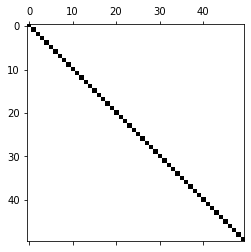

In [20]:
# Check sparsity pattern of hessian, should be diagonal
plt.spy(obj_hess_numeric(test_arg))

In [21]:
if N < 20: # only debug on small systems, don't use for big systems because numdifftools will take forever
    # sanity check against numeric jacobian and hessian
    Jac = nd.Jacobian(obj_numeric)
    print("Passed Jac test: ", np.allclose(Jac(test_arg), obj_jac_numeric(test_arg)))
    Hess = nd.Hessian(obj_numeric)
    print("Passed Hess test: ", np.allclose(Hess(test_arg), obj_hess_numeric(test_arg)))

Passed Jac test:  True
Passed Hess test:  True


## Equality Constraint

In [22]:
# Equality Constraints
C_eq = []

# # Trapezoid method
# for i in range(X_dim):
#     C_eq += [state_vars[i] - state_vars[i].subs(prev_dict) - 0.5 * h * (ode[i] + ode[i].subs(prev_dict))]

# Hermite Simpson method
mid_dict = {}
for j in range(len(control_vars)):
    mid_dict[control_vars[j]] = 0.5 * (control_vars[j] + control_vars[j].subs(prev_dict))
for i in range(X_dim):
    mid_dict[state_vars[i]] = 0.5 * (state_vars[i] + state_vars[i].subs(prev_dict)) + (h/8.0) * (ode[i].subs(prev_dict) - ode[i])
for i in range(X_dim):
    C_eq += [state_vars[i] - state_vars[i].subs(prev_dict) - (h/6.0) * (ode[i] + 4.0 * ode[i].subs(mid_dict) + ode[i].subs(prev_dict))]

C_eq = Matrix(C_eq)

ceq_lambda = Lambdify(prev_all_vars+all_vars+[h], C_eq, order='F')

# create callback for scipy
def ceq_numeric(arg):
    V = arg.reshape(N, X_dim+U_dim)
    _X = V[:,:X_dim]
    _in = np.hstack((V[:-1,:], V[1:,:],_h.reshape(-1,1)))
    _out = ceq_lambda(_in.T).T.ravel()
    initial_constr = (_X[0,:] - X_start).ravel()
    terminal_constr = (_X[-1,:] - X_goal).ravel()
    return np.hstack((_out, initial_constr, terminal_constr))

# jacobian matrix ("jac")
ceq_jac = Matrix(fast_jac(C_eq, prev_all_vars + all_vars)).T
ceq_jac_lambda = Lambdify(prev_all_vars+all_vars+[h], ceq_jac, order='F')

def ceq_jac_numeric(arg):
    V = arg.reshape(N, X_dim+U_dim)
    _in = np.hstack((V[:-1,:], V[1:,:],_h.reshape(-1,1)))
    J = ceq_jac_lambda(_in.T)

    # jac should be Num_constraints x Opt_dim
    Opt_dim = (X_dim + U_dim)
    Ceq_dim = len(ode)
    jac = np.zeros((Ceq_dim * (N-1) + 2 * X_dim, Opt_dim * N))
    for i in range(N-1):
        jac[i*Ceq_dim:i*Ceq_dim + Ceq_dim, i*Opt_dim:(i+1)*Opt_dim + Opt_dim] = J[:,:,i].T
    # initial and terminal constraint gradients are easy
    jac[Ceq_dim * (N-1):Ceq_dim * (N-1) + X_dim, :X_dim] = np.eye(X_dim)
    jac[Ceq_dim * (N-1) + X_dim:,-(X_dim+U_dim):-U_dim] = np.eye(X_dim)
    return jac

# Hessian Matrix ("hess")
n_eq = C_eq.shape[0]
# lagrange multipliers
lamb = Matrix(["lambda" + str(i) for i in range(n_eq)]).reshape(n_eq, 1)

ceq_hess = Matrix(fast_half_hess((C_eq.T * lamb)[0], prev_all_vars + all_vars))
ceq_hess_lamb = Lambdify(prev_all_vars+all_vars+list(lamb)+[h], ceq_hess, order='F')


# if the hessian is all zero, the equality constraints are linear
if len(ceq_hess.free_symbols) == 0:
    def ceq_hess_numeric(arg_x, arg_v):
        return np.zeros((arg_x.size, arg_x.size), dtype=np.float)
else:
    def ceq_hess_numeric(arg_x, arg_v):
        V = arg_x.reshape(N, X_dim+U_dim)
        _L = arg_v[:-2*X_dim].reshape(N-1, n_eq)
        _in = np.hstack((V[:-1,:], V[1:,:], _L, _h.reshape(-1,1)))
        H = ceq_hess_lamb(_in.T)

        # Reshape the lagrange multiplier vector
        hess = np.zeros((arg_x.size, arg_x.size), dtype=np.float)

        Opt_dim = (X_dim + U_dim)

        for i in range(N-1):
            hess[i*Opt_dim:(i+1)*Opt_dim + Opt_dim, i*Opt_dim:(i+1)*Opt_dim + Opt_dim] += H[:,:,i] + H[:,:,i].T

        # linear initial and terminal constraints just go to zero
        return hess


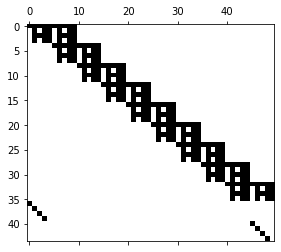

In [23]:
# Check sparsity pattern of jacobian
plt.spy(ceq_jac_numeric(test_arg))

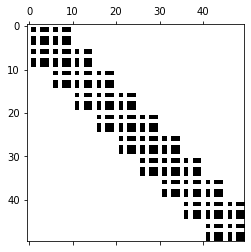

In [24]:
_lamb = np.random.random(n_eq * (N-1) + 2*X_dim)

# Check sparsity pattern of hessian
plt.spy(ceq_hess_numeric(test_arg, _lamb))

In [145]:
if N < 20: # only debug on small systems, don't use for big systems because numdifftools will take forever
    # sanity check against numeric jacobian and hessian
    Jac = nd.Jacobian(ceq_numeric)
    print("Passed Jac test: ", np.allclose(Jac(test_arg), ceq_jac_numeric(test_arg)))

    def ceq_numeric_dot_lamb(arg):
        _ceq = ceq_numeric(arg)
        return _ceq.dot(_lamb)

    Hess = nd.Hessian(ceq_numeric_dot_lamb)
    print("Passed Hess test: ", np.allclose(Hess(test_arg), ceq_hess_numeric(test_arg, _lamb)))    

Passed Jac test:  True
Passed Hess test:  True


## Optimization Problem

In [146]:
x0 = [X_start.tolist() + [1.0]]
for i in range(N-1):
    xnew = X_start + (X_goal - X_start) * i / N
    x0.append(xnew.tolist() + [1.0])
x0 = np.array(x0).ravel()

In [147]:
constr_eq = NonlinearConstraint(ceq_numeric, 
                                lb=0, 
                                ub=0, 
                                jac=ceq_jac_numeric,
                                hess=ceq_hess_numeric)

sol_opt = minimize(obj_numeric, 
                   x0, 
                   method="trust-constr", 
                   jac=obj_jac_numeric, 
                   hess=obj_hess_numeric, 
                   constraints=(constr_eq), 
                   bounds=bounds,
                   options={'sparse_jacobian': True})
print("Done")
if sol_opt.success:
    print("Success :-)")
else:
    print("Failure :-(")

print("Constraint violation: ", sol_opt.constr_violation)
print("Iterations: ", sol_opt.niter)

Done
Success :-)
Constraint violation:  2.220446049250313e-16
Iterations:  20


In [148]:
arg = sol_opt.x
V = arg.reshape(N, X_dim+U_dim)
_X = V[:, :X_dim].T
_U = V[:, X_dim:X_dim+U_dim].T

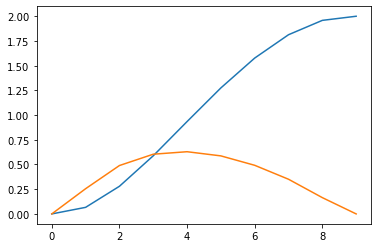

In [149]:
plt.plot(_X[0,:])
plt.plot(_X[1,:])

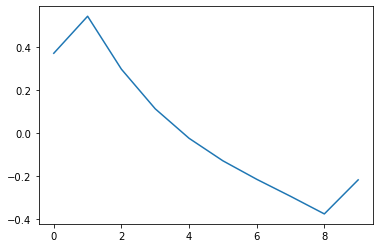

In [150]:
plt.plot(_U[0,:])